


# Document Similarity with Latent Semantic Analysis (LSA)

The following notebook walks you through doing LSA document similarity in Python using the Sklearn package. We then output the document similarity matrix as a .csv file which can be manipulated to highlight similarity between documents. We also output a heatmap which gives an initial impression of the similarity between documents. 

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (RED)](https://kb.iu.edu/d/apum). You will also need to have access to RED through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/master/Python/Py_notebooks/textPrep-Py.ipynb) before you proceed further. The textPrepPy notebook provides information and resources on how to get a Carbonate account, how to set up RED, and how to get started using the Jupyter Notebook on RED.   

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In your terminal, packages can be installed by simply typing "pip install nameofpackage --user" (minus the quotes).

- **sklearn:** Simple and efficient tools for data mining and data analysis built on NumPy, SciPy, and matplotlib.
- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **warnings:** Allows for the manipulation of warning messages in Python.
- **numpy:** a general-purpose array-processing package designed to efficiently manipulate large multi-dimensional arrays of arbitrary records without sacrificing too much speed for small multi-dimensional arrays. 
- **re:** Provides regular expression matching operations similar to those found in Perl.
- **os:** Provides a portable way of using operating system dependent functionality.
- **string:** Contains a number of functions to process standard Python strings.
- **nltk:** A leading platform for building Python programs to work with human language data.
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.

In [1]:
import sklearn
# import all of the scikit learn stuff

from __future__ import print_function
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
#from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import warnings


import numpy as np
import re
import os
from os.path import join, isfile, splitext
import string
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import sys

The code in the cell below points to a module specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different pakcages in our notebooks and their subsequent data sets.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [ ]:
sys.path.insert(0,"/N/soft/rhel7/anaconda/environments/DigHumWkshp/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/soft/rhel7/anaconda/environments/DigHumWkshp/nltk_data"

This will ignore deprecation and future warnings. All the warnings in this code are not concerning and will not break the code or cause errors in the results.

In [ ]:
# Suppress warnings from pandas library
warnings.filterwarnings("ignore", category=DeprecationWarning,
                        module="pandas", lineno=570)
warnings.filterwarnings("ignore", category=FutureWarning,
                        module = "sklearn", lineno = 1059)

### Getting your data

#### Directory where the data is stored
We simply list out the path to the directory where we can access the files or file we need. Note that we do not use any file names yet, just the path to the folder. This is because we may want to read in all the files in the directory, or just one. There are options below for doing both. We save the path as a variable named dataHome.

In [3]:
homePath = os.environ["HOME"]
dataHome = os.path.join(homePath,"IntroDocSimilarity","data","Shakespeare")
dataResults = os.path.join(homePath,"IntroDocSimilarity","Results")

### Stopwords
Here we save the nltk stopwords list as the variable 'stop_words' (minus the quotes). If you need a different language, simply change 'english' (keep the quotes) to the anglicized name of the language you wish to use (e.g. 'spanish' instead of 'espanol' or 'german' instead of 'deutsch'). If you wish to add additional words to the stop_words variable, add the word in quotes to the list in stop_words.extend(['the', 'words', 'you', 'want', 'to', 'add']). If you wish to see the list of available languages simply remove the '#' from the beginning of the last line in the cell.

In [2]:
# NLTK Stop words
stopWords = stopwords.words('english')

stopWords.extend(['would', 'said', 'says', 'also'])
#print (" ".join(stopwords.fileids()))

arabic azerbaijani danish dutch english finnish french german greek hungarian indonesian italian kazakh nepali norwegian portuguese romanian russian spanish swedish turkish


#### Add own stopword list

Here you can add your own custom stopword list. Remove all of the "#" from in front of the lines then make sure that the folders and file names for "stopWordsFilepath" match the folders and file name of your stopword document.

In [ ]:
#stopWordsFilepath = os.path.join(homePath, "IntroDocSimilarity", "data", "earlyModernStopword.txt")

#with open(stopWordsFilepath, "r",encoding = 'utf-8') as f:
    #stopWordsList = [x.strip() for x in f.readlines()]

#stopWords.extend(stopWordsList)

#### Dictionary and stemmer
Here we save what is currently an empty dictionary (token_dict) and then we save the word stemmer we are using as the variable 'stemmer'. 

A dictionary is similar to a list except it has what are called 'keys' and 'values'. This basically allows us to label or data. In this case we will be making the file names of our documents the 'keys' and the content of the file the 'values' so that each document name correlates to the content of that document. This will be done below in another cell of code.

The stemmer will truncate endings of words that end in 'ing' or 's' or 'es' et cetera. This will help ensure that words such as 'reading' and 'read' are considered as the same word so that the concept of 'to read' is given equal consideration. Additionally, the stemmer works on different languages so you can change 'english' to 'spanish' or 'german'.  A list of languages available with the nltk SnowballStemmer can be found by removing the # infront of the last line of code. 

In [4]:
tokenDict = {}
stemmer = SnowballStemmer('english')
#print(" ".join(SnowballStemmer.languages))

danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


#### Stemming and tokenization functions
Here we create two functions. The first is where we will use the stemmer variable above to create a function that will stem the words in our documents when applied.

The second tokenizes our documents which means it splits it into individual words. This function uses the 'stem_tokens' function as part of it so later in the code we will only need to apply the 'tokenize' function. 

You should not need to make any changes to this block of code.

In [5]:
def stemTokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stemTokens(tokens, stemmer)
    return stems

#### Read in documents
Now we read in our documents and also perform some text cleaning. This code lower cases all the words as well as removes punctuation. Then it adds the file names and cleaned content of each file to our previously empty 'token_dict' dictionary above. You should not need to make any changes to this code. 

In [6]:
for subdir, dirs, files in os.walk(dataHome):
    for file in files:
        if file.startswith('.'):
                continue
        filePath = subdir + os.path.sep + file
        with open(filePath, 'r', encoding = 'utf-8') as file:
            text = file.read()
            lowers = text.lower()
            noPunctuation = lowers.translate(str.maketrans('','', string.punctuation))
            tokenDict[file] = noPunctuation

Let's check and see if our dictionary now has our data.

In [7]:
print(list(tokenDict.keys())[0:10])

['1600TroilusAndCressida.txt', '1595MidsummerNightsDream.txt', '1605KingLear.txt', '1599JuliusCaesar.txt', '1608Coriolanus.txt', '1612KingHenry8.txt', '1595RomeoAndJuliet.txt', '1596KingJohn.txt', '1596MerchantOfVenice.txt', '1590TamingOfTheShrew.txt']


#### Tfidf Vectorizer

Here we weight the importance of each word in the document. This done using Term Frequency-Inverse Document Frequency (Tfidf). This considers how important a word is based on the frequency in the whole corpus as well as in individual documents. This allows for words that might not have a high frequency in an entire collection, but do have a high frequency in one or two documents when compared to other words to still be given a higher level of importance throughout the text.

In [8]:
vectorizer = TfidfVectorizer(tokenizer = tokenize, stop_words=stopWords)
dtm = vectorizer.fit_transform(tokenDict.values())
testDF = pd.DataFrame(dtm.toarray(), index=tokenDict.keys(), columns = vectorizer.get_feature_names())
testDF = testDF.sort_index(axis = 0)

Now let's take a look at our data frame where the rows are the documents and the columns are the terms. To adjust which part of the data frame you see in the output change the numbers in the square brackets. To see the 10th thru the 20th row and the 100th to 110th column the numbers in the brackets should read [10:20, 100:110]. So the first set of numbers is for what rows you wish to see and the second set dictate the columns. 

In [9]:
testDF.iloc[:10, 7640:7650]

,manchild,manchus,mandat,mandragora,mandrak,mane,manent,mangi,mangl,manhood
1589TwoGentlemenOfVerona.txt,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
1590TamingOfTheShrew.txt,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
1591KingHenry6_1.txt,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
1591KingHenry6_2.txt,0.0,0.0,0.0,0.0,0.00153,0.0,0.0,0.0,0.000000,0.000816
1591KingHenry6_3.txt,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.001057,0.002565
1591TitusAndronicus.txt,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.001255,0.000000
1592KingRichard3.txt,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000713
1594ComedyOfErrors.txt,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
1594LovesLaboursLost.txt,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
1595KingRichard2.txt,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000


The below code just outputs all of the words that make up the columns once we have broken our corpus down into a Tfidf matrix.

In [10]:
# Get words that correspond to each column
vectorizer.get_feature_names()

['2d',
 '2s',
 '4d',
 '5s',
 '6d',
 '8d',
 'a',
 'aaron',
 'abandon',
 'abas',
 'abash',
 'abat',
 'abatfowl',
 'abbess',
 'abbey',
 'abbot',
 'abbrevi',
 'abc',
 'abe',
 'abel',
 'abergavenni',
 'abet',
 'abhor',
 'abhorredst',
 'abhorson',
 'abi',
 'abid',
 'abil',
 'abird',
 'abject',
 'abjur',
 'abl',
 'ableed',
 'abler',
 'aboard',
 'abod',
 'abomin',
 'abort',
 'abound',
 'about',
 'abov',
 'abraham',
 'abram',
 'abreast',
 'abreed',
 'abrew',
 'abridg',
 'abroach',
 'abroad',
 'abrog',
 'abrupt',
 'absenc',
 'absent',
 'abseybook',
 'absolut',
 'absolv',
 'abstain',
 'abstemi',
 'abstin',
 'abstract',
 'absurd',
 'absyrti',
 'abund',
 'abus',
 'abut',
 'abysm',
 'academ',
 'acapr',
 'accent',
 'accept',
 'access',
 'accessori',
 'accid',
 'accident',
 'accit',
 'acclam',
 'accommod',
 'accompani',
 'accomplic',
 'accomplish',
 'accord',
 'accost',
 'account',
 'accountst',
 'accouter',
 'accoutr',
 'accru',
 'accumul',
 'accurs',
 'accus',
 'accustom',
 'ace',
 'ach',
 'acheron'

#### Run SVD and Cosine Similarity

Here we run our Tfidf matrix created above through Singular Value Decomposition and then calculate the Cosine Similarity of the documents to one another. 

Singular Value Decomposition condenses our Tfidf matrix down a bit to make it easier to process. Here we also set the number of dimensions (n_components), how many times we iterate over the corpus, and then set the random_state so that the results are reproducable.

Cosine similarity is where we measure how similar the documents are to one another. The result is a number between -1 and 1 with 1 being a perfect match (which we will get when the document is compared to itself) and -1 being completely different which we might get if we have a document of all numbers and one of all words with no numbers at all. Usually, even documents that are about unrelated topics share some common words and so are not completely dissimilar.

In [11]:
# Fit LSA. Use algorithm = "randomized" for large datasets
lsa = TruncatedSVD(n_components = 100, n_iter = 100, random_state = 42)
dtmLsa = lsa.fit_transform(dtm)
cosineSim = cosine_similarity(dtmLsa)

#### Save as a data frame

Now we simply save the results as a data frame. First we create the data frame and say we want the rows and columns to be labeled with the file names. Then we sort the columns in alphanumeric order by column header, then we sort the rows alphanumericaly by row label. Next we save the data frame as a .csv file. This is where you may want to make a change by changing the file name to fit your data. Lastly we add color based on the numbers in the data frame cells, so right now we have it set so that the mor dissimilar the more red the cell will be and the more similar the more green it will be with those in the middle looking more yellow. You can adjust the colors by changing the cmap = 'RdYlGn' to something else. Options for colors can be found here: [https://matplotlib.org/tutorials/colors/colormaps.html](https://matplotlib.org/tutorials/colors/colormaps.html) 

In [12]:
df = pd.DataFrame(cosineSim, index = tokenDict.keys(), columns=tokenDict.keys())
dfS = df[sorted(df)]
sortedDf = dfS.sort_index(axis = 0)
sortedDf.to_csv(os.path.join(dataResults, "shakespeareSimilarityMatrix.csv"))
colorDf = sortedDf.style.background_gradient(cmap='RdYlGn')
colorDf


### Plot Heatmap

Now we plot a heatmap and save it as a .png file for use in a paper, presentation, or even a website. 

First we import two visualization packages, seaborn and matplotlib. 

Next we set the figure and font size. Feel free to adjust the numbers so they better fit your data. For the figure size it goes by x axis then y axis or width then height. The font_scale adjusts the font size for the whole graph.

Next we name the data frame we are turning into a heatmap and the color scheme we want to use. Other options for color schemes can be found here: [https://matplotlib.org/tutorials/colors/colormaps.html](https://matplotlib.org/tutorials/colors/colormaps.html)

The figure.savefig line is the only other one where you may want to make changes, specifically in the file name. Change the name to fit your data. You may also want to change the dpi depending on how you plan to use the image later.

Then we plot our heatmap!

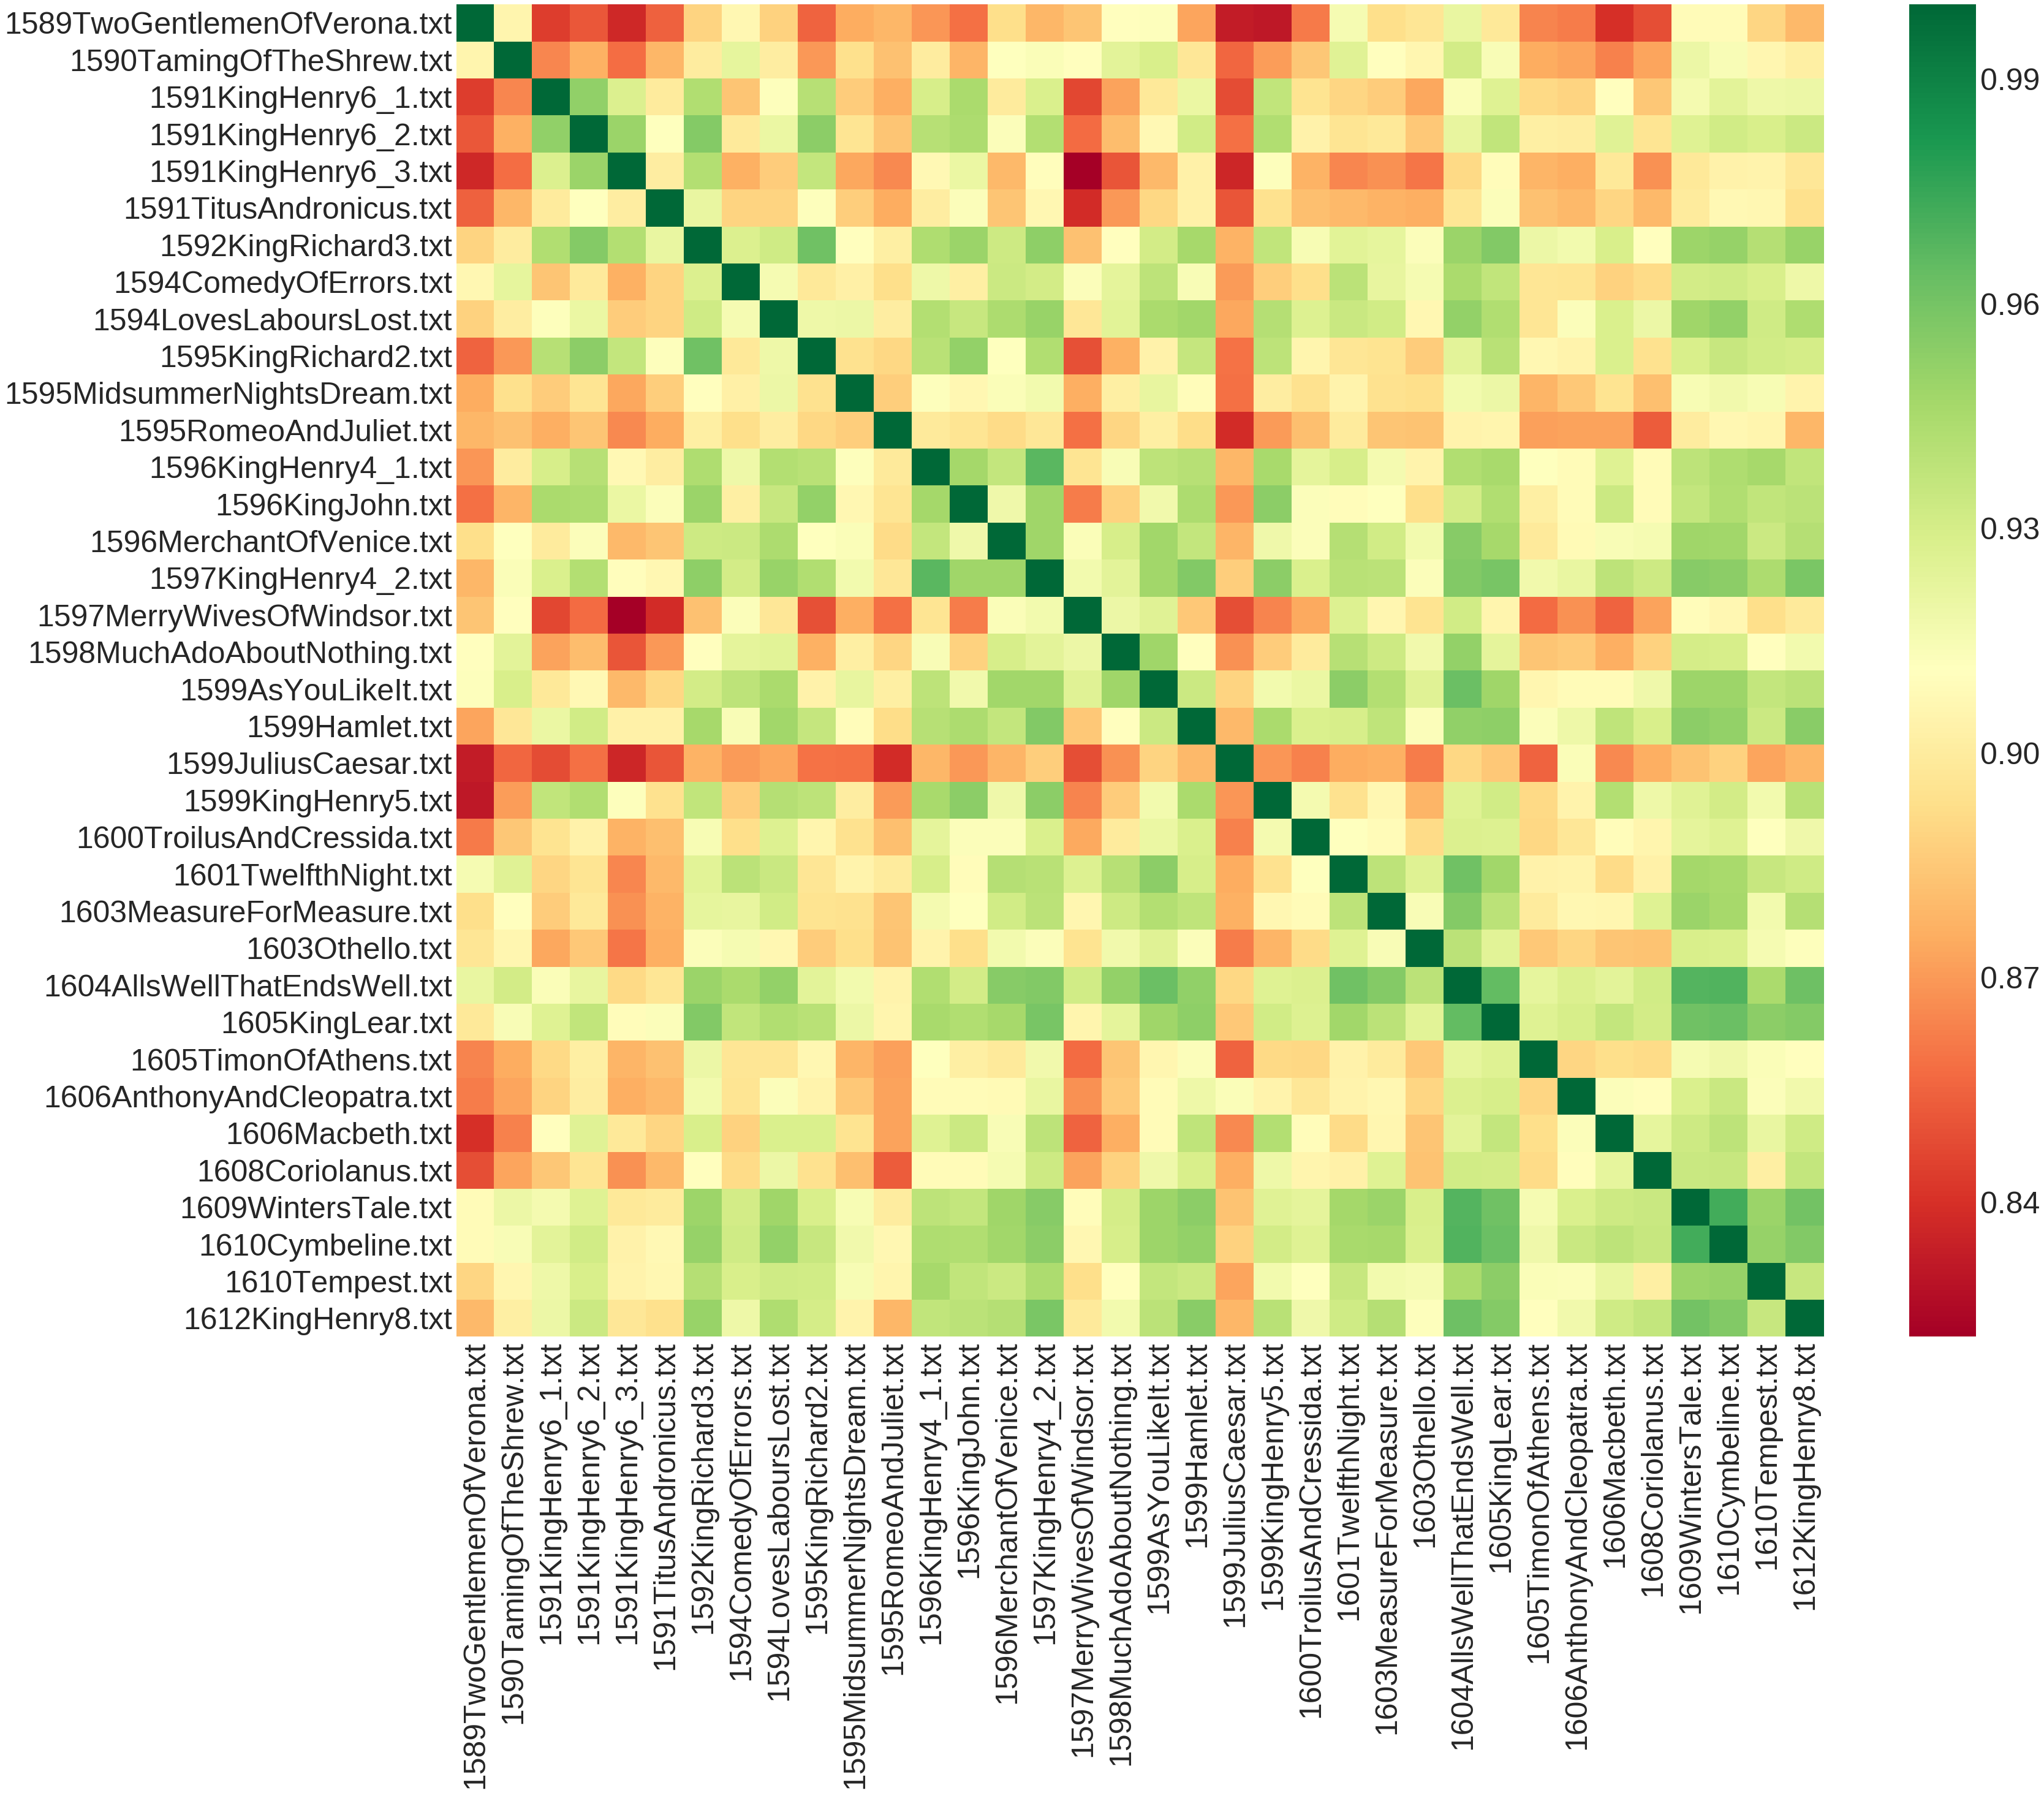

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(50,40)}, font_scale = 5)
ax = sns.heatmap(sortedDf, cmap = 'RdYlGn')
#figure = ax.get_figure()
ax.figure.savefig(os.path.join(dataResults, 'shakespeareDocSimHeatmap.png'), dpi = 300, bbox_inches='tight')
plt.show()

## VOILA!!

This notebook was adapted from https://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf at Colorado University, Boulder. Accessed on 02/01/2019.